# Yelp Reviews - Restaurant Review Topic Analysis  
* Ankur Vishwakarma  
* Metis SF Winter 2018

## Notebook 1 - Extracting only restaurant reviews

In [1]:
# import necessary modules
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# stop/start mongo service
!sudo service mongod stop
!sudo service mongod start

In [3]:
# connecting the MongoDB
client = MongoClient()
db = client.yelp

# print number of rows in each collection
for c in db.collection_names():
    print('{:10}'.format(c), '{:>10,}'.format(db[c].count()))

checkin       146,350
review      5,261,669
user        1,326,101
tip         1,098,325
business      174,567


In [4]:
# connecting collections
reviews = db.review
businesses = db.business

In [5]:
# some Mongo testing
one_review = reviews.find_one()
one_business = businesses.find_one({'business_id':one_review['business_id']})
print('{:6}'.format('Name:'), one_business['name'])
print('{:6}'.format('City:'), one_business['city'])
pprint(one_business)

Name:  Schwartz's
City:  Montréal
{'_id': ObjectId('5a95ffb4ae7ebe8216ac99b9'),
 'address': '3895 Boulevard Saint-Laurent',
 'attributes': {'Alcohol': 'none',
                'Ambience': {'casual': True,
                             'classy': False,
                             'hipster': False,
                             'intimate': False,
                             'romantic': False,
                             'touristy': False,
                             'trendy': False,
                             'upscale': False},
                'BikeParking': True,
                'BusinessAcceptsCreditCards': False,
                'BusinessParking': {'garage': False,
                                    'lot': False,
                                    'street': True,
                                    'valet': False,
                                    'validated': False},
                'Caters': True,
                'GoodForKids': True,
                'GoodForMeal': {'breakfast

In [8]:
# how many businesses in each state
states = []
num_bsns = []
for i in businesses.aggregate([{"$group":{"_id":"$state", 'count':{"$sum":1}}}]):
    states.append(i['_id'])
    num_bsns.append(i['count'])

# create a dataframe
businesses_state = {'states':states, 'businesses':num_bsns}
bsns_state = pd.DataFrame(data=businesses_state, columns=['states', 'businesses'])

# get top 10 states
bsns_state_top10 = bsns_state.sort_values(by='businesses', ascending=False).head(10)

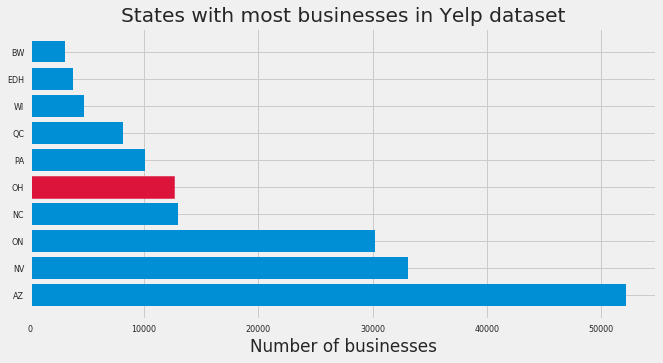

In [120]:
# plot the top 10 states by business count
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
barlist = plt.barh(range(10), bsns_state_top10.businesses)
barlist[4].set_color('crimson')
plt.title('States with most businesses in Yelp dataset')
plt.yticks(range(10), bsns_state_top10.states)
plt.xlabel('Number of businesses');

* We'll work with reviews from the state of Ohio since it looks like a decent enough dataset of 10,000+ businesses (but not overly large that'll tax computation resources). 
* Next, we'll get all reviews from Mongo then filter out the ones that we do not need in Pandas.

In [7]:
%%time
# return only OH business IDs
oh_bsns = []
oh_name = []
oh_cats = []
oh_city = []
oh_attr = []
oh_revs = []
oh_star = []
for i in businesses.find({'state':'OH'}, {'business_id':1, 'name':1, 'categories':1, 'stars':1,
                                          'city':1, 'attributes':1, 'review_count':1, '_id':0}):
    oh_bsns.append(i['business_id'])
    oh_name.append(i['name'])
    oh_cats.append(i['categories'])
    oh_city.append(i['city'])
    oh_attr.append(i['attributes'])
    oh_revs.append(i['review_count'])
    oh_star.append(i['stars'])

oh_dict = {'id':oh_bsns, 'categories':oh_cats, 'city':oh_city, 'attributes':oh_attr, 
           'reviews':oh_revs, 'name':oh_name, 'stars':oh_star}
oh = pd.DataFrame(data=oh_dict, columns=['id', 'name', 'city', 'stars', 'reviews', 'categories', 'attributes'])
print('Number of businesses in Ohio in this Yelp dataset:', '{:,}'.format(len(oh_bsns)))

# load all reviews into a dataframe
df_all = pd.DataFrame(list(reviews.find({})))

Number of businesses in Ohio in this Yelp dataset: 12,609
CPU times: user 124 ms, sys: 8 ms, total: 132 ms
Wall time: 209 ms


In [9]:
# get dataframe of business IDs of only restaurants
def find_in_list(stringy, listy):
    """Returns True/False if stringy is found in listy"""
    if stringy in listy:
        return True
    else:
        return False

# get business IDs of only a particular business type
businesses_to_investigate = 'Restaurants'
oh_rest = oh[oh.categories.map(lambda x: find_in_list(businesses_to_investigate, x))]

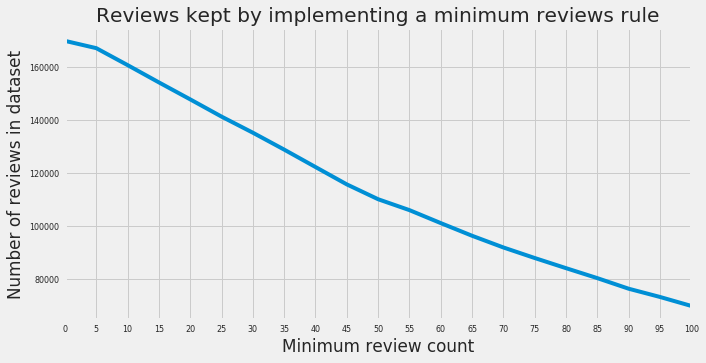

In [114]:
# how many review counts do the restaurants have
revs_x = np.arange(0, 101, 5) # list of numbers to use as minimum reviews treshold
rest_y = [oh_rest[oh_rest.reviews >= x].reviews.sum() for x in revs_x]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
plt.plot(revs_x, rest_y)
plt.xlim((min(revs_x), max(revs_x)))
plt.xticks(revs_x, revs_x)
plt.title('Reviews kept by implementing a minimum reviews rule')
plt.xlabel('Minimum review count')
plt.ylabel('Number of reviews in dataset');

Based on the chart above, even by keeping restaurants with a minimum of 30 reviews, we will still have over 130,000 reviews to analyze.

In [10]:
oh_rest = oh_rest[oh_rest.reviews >= 30]

In [11]:
# write to CSV restaurant information so we can use it later
oh_rest.to_csv('OH_restaurants.csv')

In [116]:
%%time
# keep only reviews that belong to OH restaurants
df = df_all[df_all.business_id.isin(oh_rest.id.values)]

CPU times: user 14.3 s, sys: 76 ms, total: 14.3 s
Wall time: 14.3 s


In [117]:
# write to CSV for ease of reading in later
df.info()
df.to_csv('reviews_OH_restaurants.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135270 entries, 536 to 5261656
Data columns (total 10 columns):
_id            135270 non-null object
business_id    135270 non-null object
cool           135270 non-null int64
date           135270 non-null object
funny          135270 non-null int64
review_id      135270 non-null object
stars          135270 non-null int64
text           135270 non-null object
useful         135270 non-null int64
user_id        135270 non-null object
dtypes: int64(4), object(6)
memory usage: 11.4+ MB


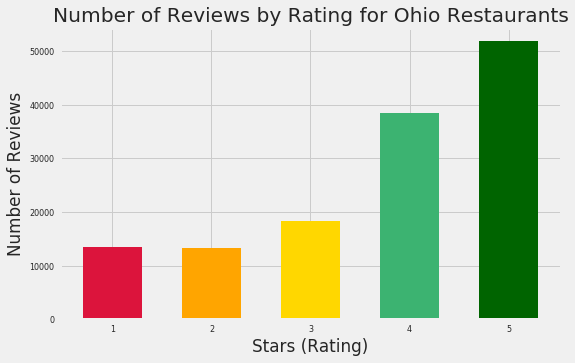

In [118]:
# plot how many reviews we have of each star
star_x = df.stars.value_counts().index
star_y = df.stars.value_counts().values

plt.figure(figsize=(8,5))
# colors are in the order 5, 4, 3, 1, 2
bar_colors = ['darkgreen', 'mediumseagreen', 'gold', 'crimson', 'orange']
plt.bar(star_x, star_y, color=bar_colors, width=.6)
plt.xlabel('Stars (Rating)')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Rating for Ohio %s' %(businesses_to_investigate));

We'll group all 1 and 2-star reviews as **negative** and all 4 and 5-star reviews as **positive**. 

In [119]:
pos_reviews = df.text[df.stars>3].values
neg_reviews = df.text[df.stars<3].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  90,311
Negative Reviews:  26,733


Next notebook - [2_text_processing](2_text_processing.ipynb)